NameError: name '__file__' is not defined

In [1]:
# %%
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 13 10:50:25 2019

@author: Keshik
"""

import torch
import numpy as np
from torchvision import transforms
import torchvision.models as  models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from dataset import PascalVOC_Dataset, mydataset
import torch.optim as optim
from train import train_model, test
from utils import encode_labels, plot_history
import os
import torch.utils.model_zoo as model_zoo
import utils
from calc import *
import matplotlib.pyplot as plt
import pathlib

# learning

In [2]:
data_dir = '../data/'
num = 6
# lr = [1e-5, 5e-3] # 
lr = [1.5e-4, 5e-2]
epochs = 20
batch_size = 32
model_name = 'vit_tiny'
download_data = False
save_results = True

In [3]:
from tqdm import tqdm
import torch
import gc
import os
from utils import get_ap_score
import numpy as np

def test(model, device, test_loader, returnAllScores=False):
    """
    Evaluate a deep neural network model
    
    Args:
        model: pytorch model object
        device: cuda or cpu
        test_dataloader: test images dataloader
        returnAllScores: If true addtionally return all confidence scores and ground truth 
        
    Returns:
        test loss and average precision. If returnAllScores = True, check Args
    """
    model.train(False)
    
    running_loss = 0
    running_ap = 0
    
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    m = torch.nn.Sigmoid()
    
    if returnAllScores == True:
        all_scores = np.empty((0, 20), float)
        ground_scores = np.empty((0, 20), float)
        
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            #print(data.size(), target.size())
            target = target.float()
            data, target = data.to(device), target.to(device)
            bs, ncrops, c, h, w = data.size()

            output = model(data.view(-1, c, h, w))
            output = output.view(bs, ncrops, -1).mean(1)
            
            loss = criterion(output, target)
            
            running_loss += loss # sum up batch loss
            running_ap += get_ap_score(torch.Tensor.cpu(target).detach().numpy(), torch.Tensor.cpu(m(output)).detach().numpy()) 
            
            if returnAllScores == True:
                all_scores = np.append(all_scores, torch.Tensor.cpu(m(output)).detach().numpy() , axis=0)
                ground_scores = np.append(ground_scores, torch.Tensor.cpu(target).detach().numpy() , axis=0)
            
            del data, target, output
            gc.collect()
            torch.cuda.empty_cache()

    num_samples = float(len(test_loader.dataset))
    avg_test_loss = running_loss.item()/num_samples
    test_map = running_ap/num_samples
    
    print('test_loss: {:.4f}, test_avg_precision:{:.3f}'.format(
                    avg_test_loss, test_map))
    
    
    if returnAllScores == False:
        return avg_test_loss, test_map
    
    return avg_test_loss, test_map, all_scores, ground_scores

In [4]:
"""
Main function

Args:
    data_dir: directory to download Pascal VOC data
    model_name: resnet18, resnet34 or resnet50
    num: model_num for file management purposes (can be any postive integer. Your results stored will have this number as suffix)
    lr: initial learning rate list [lr for resnet_backbone, lr for resnet_fc] 
    epochs: number of training epochs
    batch_size: batch size. Default=16
    download_data: Boolean. If true will download the entire 2012 pascal VOC data as tar to the specified data_dir.
    Set this to True only the first time you run it, and then set to False. Default False 
    save_results: Store results (boolean). Default False
    
Returns:
    test-time loss and average precision
    
Example way of running this function:
    if __name__ == '__main__':
        main('../data/', "resnet34", num=1, lr = [1.5e-4, 5e-2], epochs = 15, batch_size=16, download_data=False, save_results=True)
"""

model_dir = os.path.join("../models", model_name)

if not os.path.isdir(model_dir):
    os.mkdir(model_dir) 

model_urls = {
'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}

from network import define_tsnet

model_collections_dict = {
        "resnet18": models.resnet18(),
        "resnet34": models.resnet34(),
        "resnet50": models.resnet50(), 
        "vit_tiny": define_tsnet("deit_tiny", num_class=20, pretrained=True),
        }

# Initialize cuda parameters
use_cuda = torch.cuda.is_available()
np.random.seed(2019)
torch.manual_seed(2019)
device = torch.device("cuda" if use_cuda else "cpu")

print("Available device = ", device)
model = model_collections_dict[model_name]
model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
#model.load_state_dict(model_zoo.load_url(model_urls[model_name]))
if model_name != "vit_tiny":
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 20)
model.to(device)
        
optimizer = optim.SGD([   
        {'params': list(model.parameters())[:-1], 'lr': lr[0], 'momentum': 0.9},
        {'params': list(model.parameters())[-1], 'lr': lr[1], 'momentum': 0.9}
        ])

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 12, eta_min=0, last_epoch=-1)


Available device =  cuda


In [5]:
path = pathlib.Path('../data/PASCAL_VOC_2012/')
val_imgs = np.load(path.joinpath('PASCAL_VOC_val_224_Img.npy'))
val_labels = np.load(path.joinpath('PASCAL_VOC_val_224_Label.npy'))
train_imgs = np.load(path.joinpath('PASCAL_VOC_train_224_Img.npy'))
train_labels = np.load(path.joinpath('PASCAL_VOC_train_224_Label.npy'))

val_imgs = np.transpose(val_imgs, (0, 2, 3, 1))*255
train_imgs = np.transpose(train_imgs, (0, 2, 3, 1))*255
val_imgs = val_imgs.astype(np.uint8)
train_imgs = train_imgs.astype(np.uint8)

assert(val_imgs.shape[0] == val_labels.shape[0])
assert(train_imgs.shape[0] == train_labels.shape[0])

In [6]:
# Imagnet values
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToPILImage(),
                                        # transforms.RandomChoice([
                                        #     transforms.ColorJitter(brightness=(0.80, 1.20)),
                                        #     transforms.RandomGrayscale(p = 0.25)
                                        #     ]),
                                        # transforms.RandomHorizontalFlip(p = 0.25),
                                        # transforms.RandomRotation(25),
                                        transforms.Resize(224), 
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean = mean, std = std),
                                    ])
transformations_valid = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(224), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean = mean, std = std),
                                        ])

# # model.load_state_dict(torch.load(weights_file_path))
transformations_test = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(224), 
                                        transforms.FiveCrop(224), 
                                        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                        transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean = mean, std = std)(crop) for crop in crops])),
                                        ])

train_dataset = mydataset(train_imgs, train_labels, transforms=transformations)
val_dataset = mydataset(val_imgs, val_labels, transforms=transformations_valid)
test_dataset = mydataset(val_imgs, val_labels, transforms=transformations_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [7]:
model_dir

'../models/vit_tiny'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/suncheol/code/VFL/.venv/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


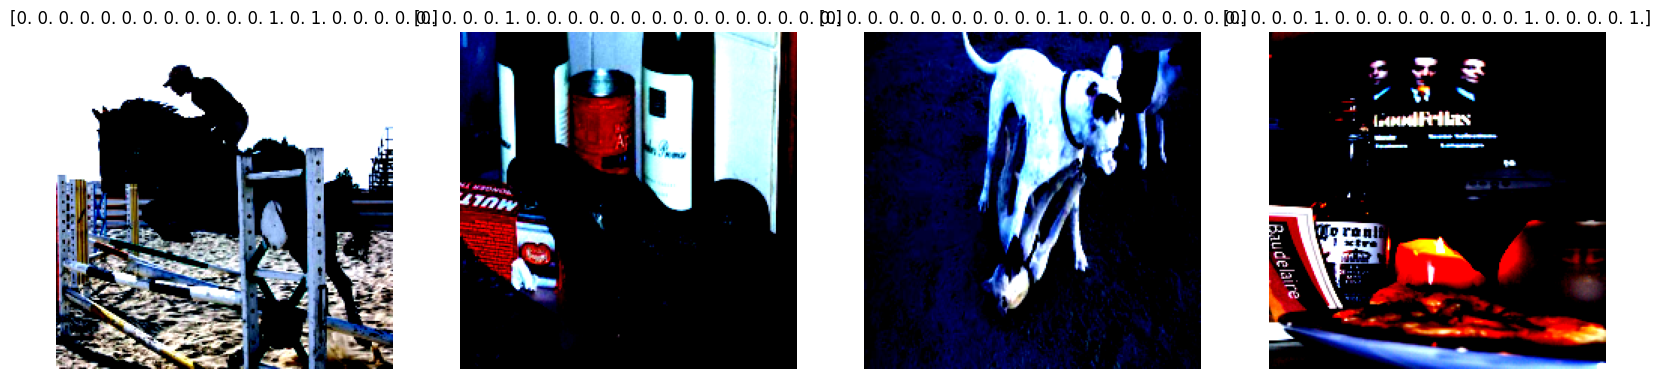

In [8]:
# show sample images for training
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(train_dataset[i][0].permute(1, 2, 0))
    ax[i].set_title(train_dataset[i][1])
    ax[i].axis('off')

Loading best weights
Evaluating model on test set
Loading best weights


100%|██████████| 182/182 [00:49<00:00,  3.65it/s]


test_loss: 2.9633, test_avg_precision:0.727
opt threshold = 0.30
accuracy = 0.50
precision = 0.57
recall = 0.59
f1 score = 0.55
optimal threshold = 0.30000000000000004 best f1 score = 0.55


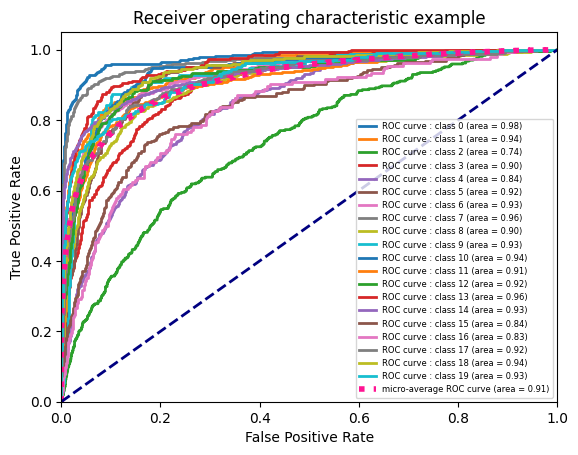

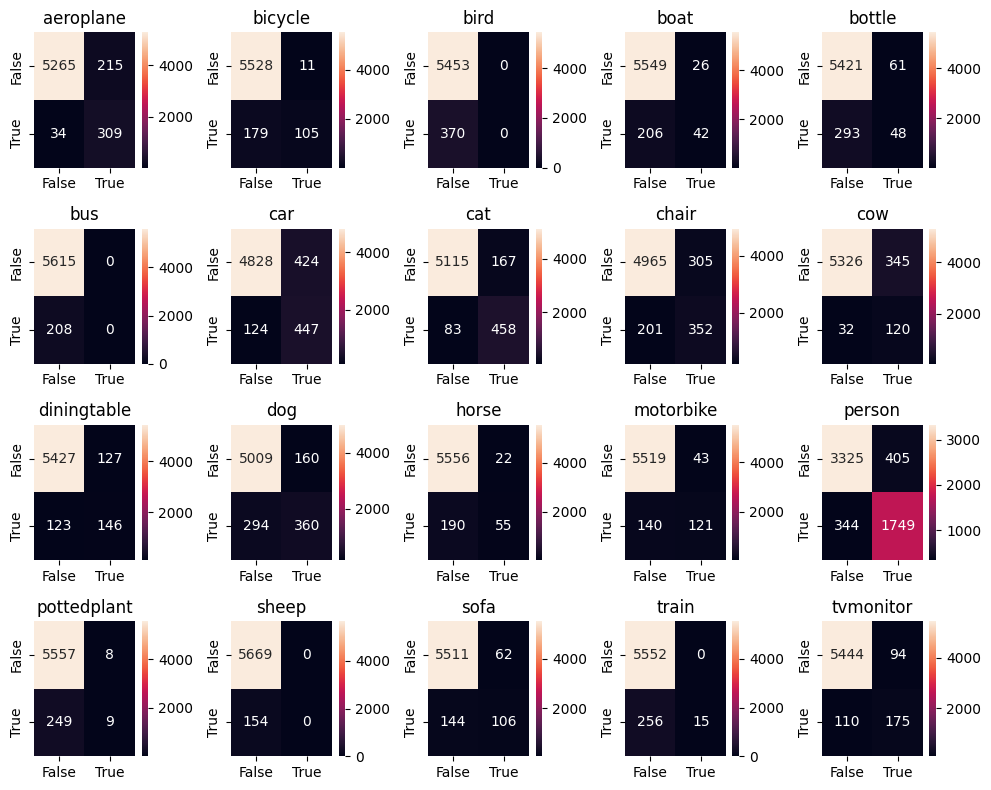

Loading best weights
Evaluating model on test set
Loading best weights


100%|██████████| 182/182 [00:47<00:00,  3.86it/s]


test_loss: 2.5249, test_avg_precision:0.789
opt threshold = 0.30
accuracy = 0.59
precision = 0.67
recall = 0.67
f1 score = 0.64
optimal threshold = 0.30000000000000004 best f1 score = 0.64


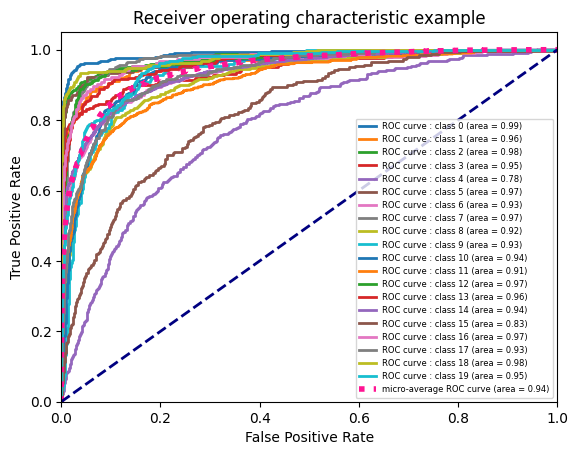

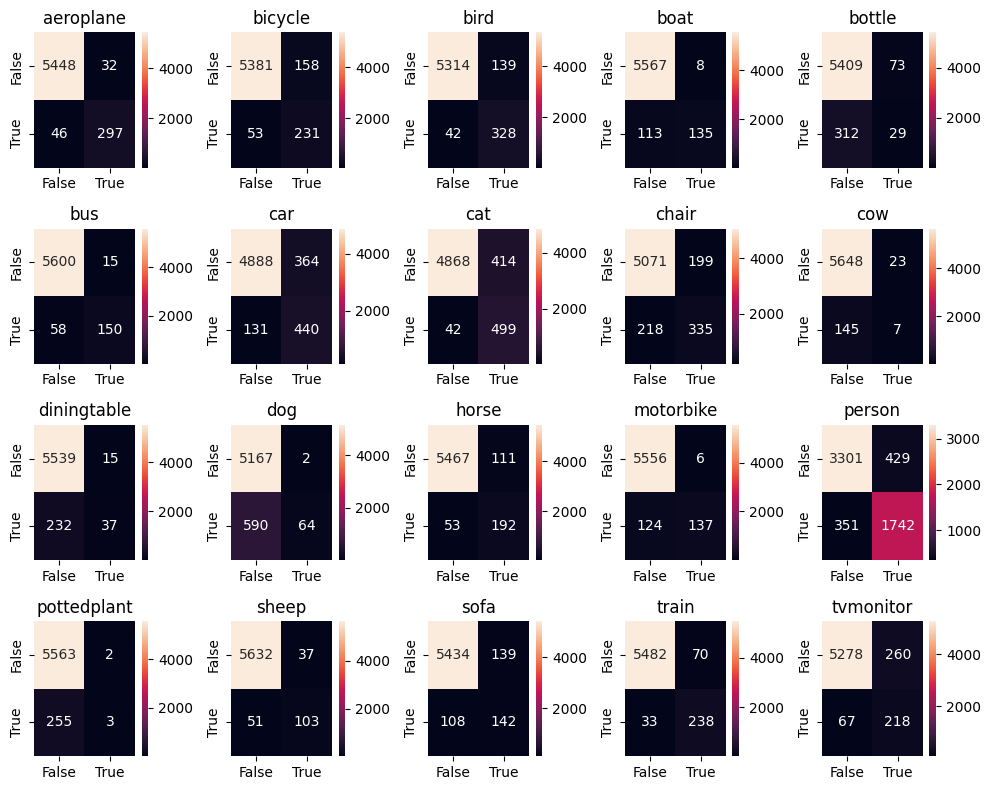

Loading best weights
Evaluating model on test set
Loading best weights


100%|██████████| 182/182 [00:47<00:00,  3.84it/s]


test_loss: 2.2587, test_avg_precision:0.851
opt threshold = 0.30
accuracy = 0.63
precision = 0.72
recall = 0.72
f1 score = 0.69
optimal threshold = 0.30000000000000004 best f1 score = 0.69


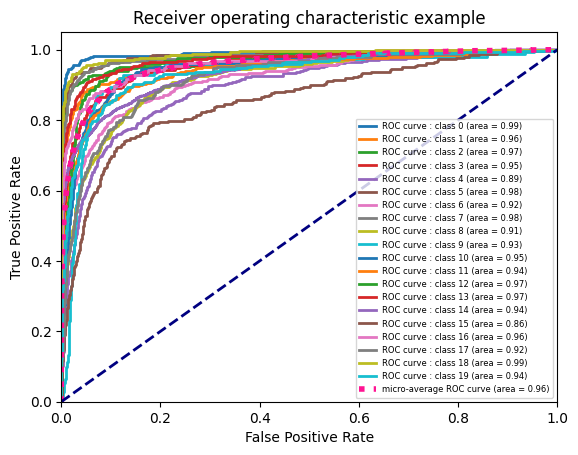

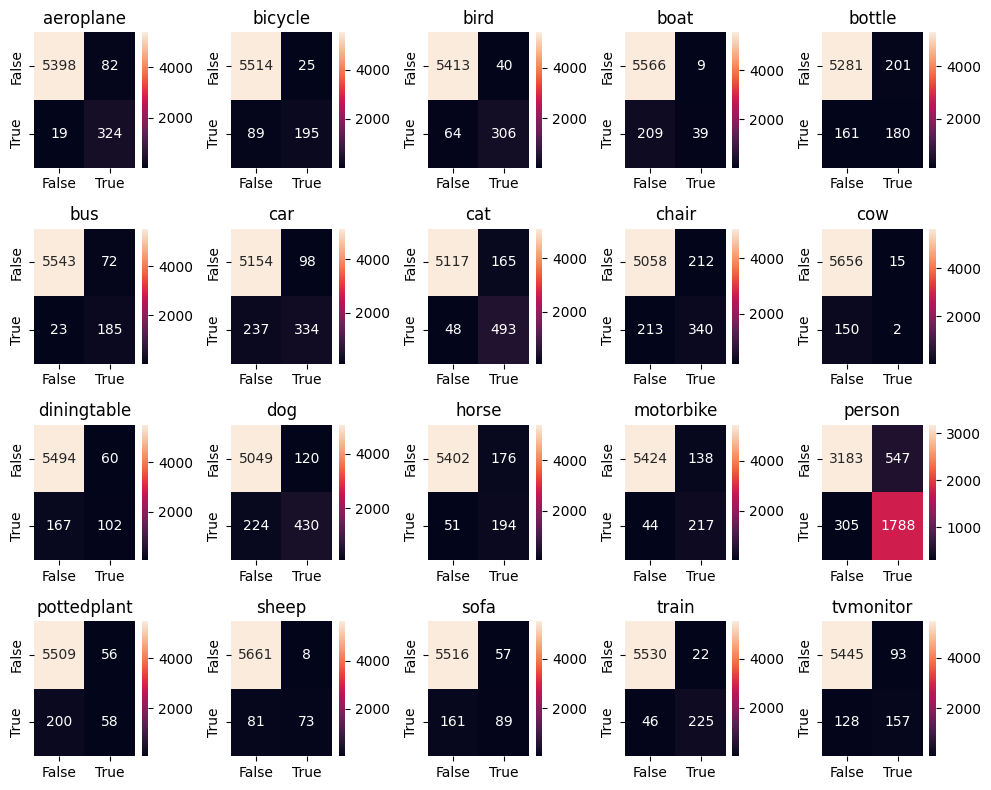

Loading best weights
Evaluating model on test set
Loading best weights


100%|██████████| 182/182 [00:47<00:00,  3.87it/s]


test_loss: 2.3086, test_avg_precision:0.838
opt threshold = 0.30
accuracy = 0.63
precision = 0.72
recall = 0.72
f1 score = 0.69
optimal threshold = 0.30000000000000004 best f1 score = 0.69


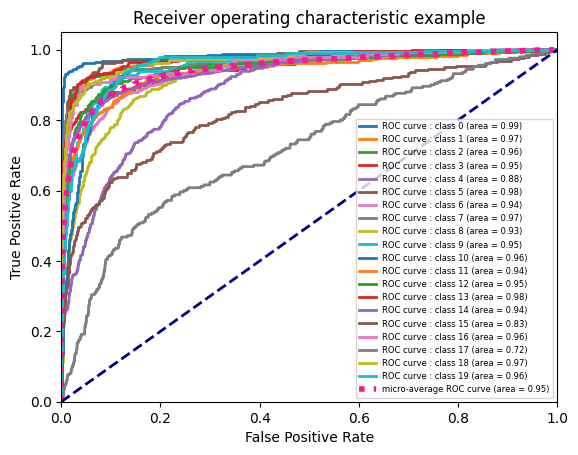

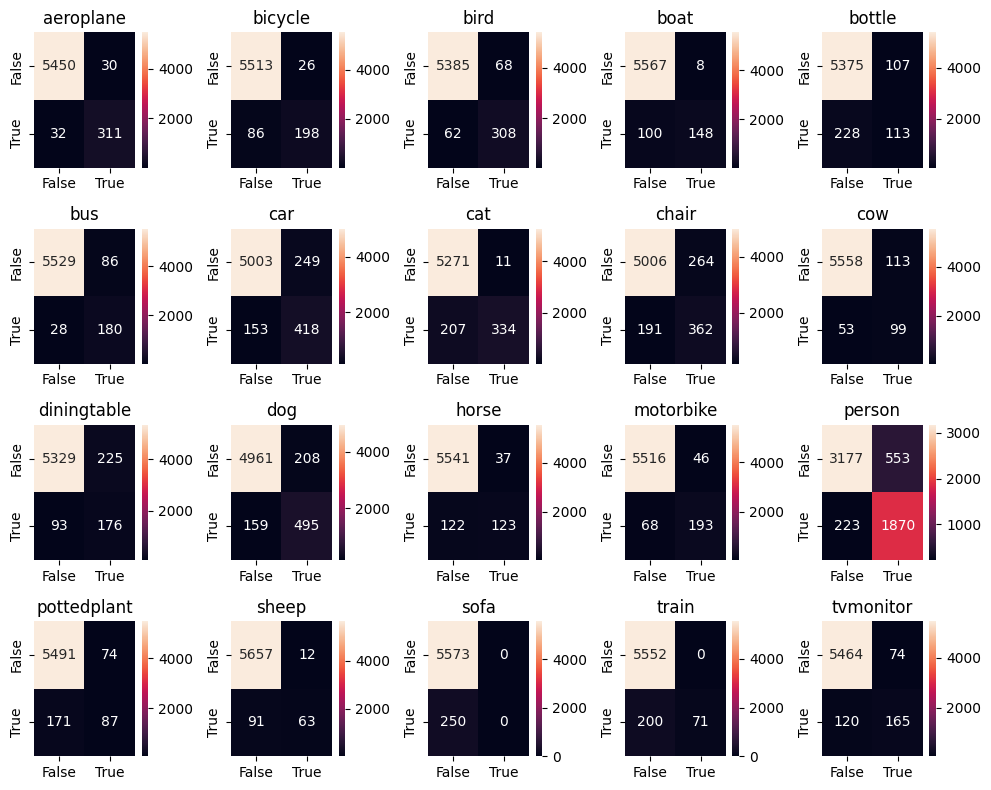

Loading best weights
Evaluating model on test set
Loading best weights


100%|██████████| 182/182 [00:46<00:00,  3.94it/s]


test_loss: 2.3787, test_avg_precision:0.823
opt threshold = 0.30
accuracy = 0.61
precision = 0.70
recall = 0.70
f1 score = 0.67
optimal threshold = 0.30000000000000004 best f1 score = 0.67


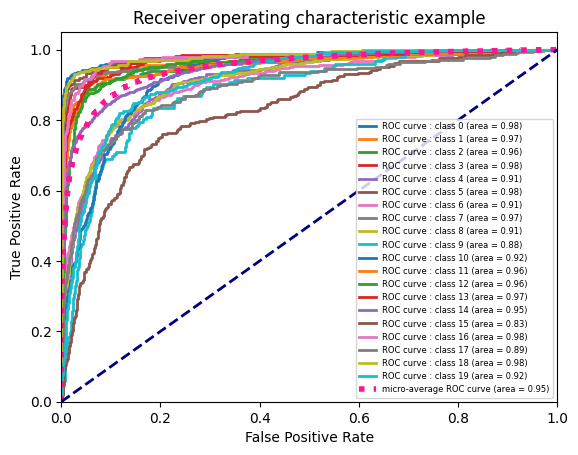

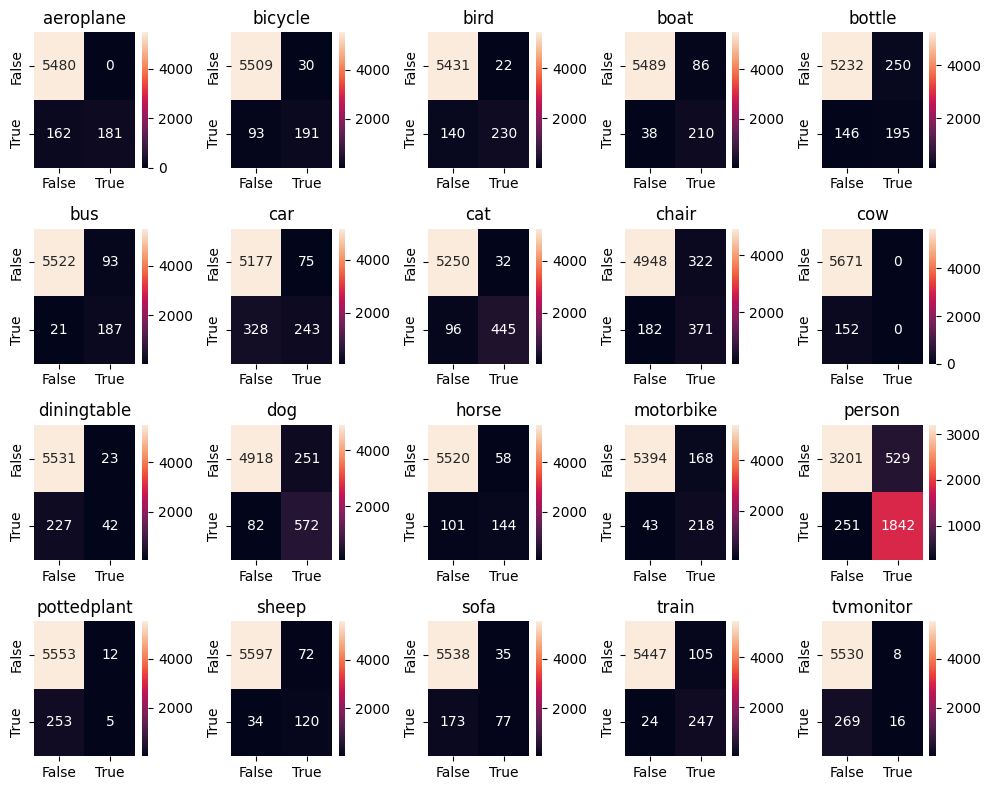

In [9]:
# for i, (img, labels) in enumerate(train_loader):
#     print(img.shape)
#     break
def test_score(num, save_results=True):
    # Load the best weights before testing
    weights_file_path = os.path.join(model_dir, "model-{}.pth".format(num))
    if os.path.isfile(weights_file_path):
        print("Loading best weights")
        model.load_state_dict(torch.load(weights_file_path))

    log_file = open(os.path.join(model_dir, "log-{}.txt".format(num)), "w+")
    log_file.write("----------Experiment {} - {}-----------\n".format(num, model_name))
    log_file.write("transformations == {}\n".format(transformations.__str__()))
    # trn_hist, val_hist = train_model(model, device, optimizer, scheduler, train_loader, val_loader, model_dir, num, epochs, log_file)
    torch.cuda.empty_cache()

    # plot_history(trn_hist[0], val_hist[0], "Loss", os.path.join(model_dir, "loss-{}".format(num)))
    # plot_history(trn_hist[1], val_hist[1], "Accuracy", os.path.join(model_dir, "accuracy-{}".format(num)))    
    log_file.close()

    #---------------Test your model here---------------------------------------
    # Load the best weights before testing
    print("Evaluating model on test set")
    print("Loading best weights")

    if save_results:
        loss, ap, scores, gt = test(model, device, test_loader, returnAllScores=True)
        # gt_path, scores_path, scores_with_gt_path = os.path.join(model_dir, "gt-{}.csv".format(num)), os.path.join(model_dir, "scores-{}.csv".format(num)), os.path.join(model_dir, "scores_wth_gt-{}.csv".format(num))
        # utils.save_results(val_loader.dataset.imgs, gt, utils.object_categories, gt_path)
        # utils.save_results(val_loader.dataset.imgs, scores, utils.object_categories, scores_path)
        # utils.append_gt(gt_path, scores_path, scores_with_gt_path)
        # utils.get_classification_accuracy(gt_path, scores_path, os.path.join(model_dir, "clf_vs_threshold-{}.png".format(num)))
                
        y_score = np.array(scores) 
        y_test = np.array(gt)
        # y_score = np.ones(scores.shape)

        th_ls = [0.1 * i for i in range(10)]
        opt_th = 0
        best_acc = 0
        def get_metrics(y_test, y_score, th):
            y_pred = (y_score > th).astype(int)
            acc = getAccuracy(y_test, y_pred)
            pre = getPrecision(y_test, y_pred)
            rec = getRecall(y_test, y_pred)
            f1 = getF1score(y_test, y_pred)
            return acc, pre, rec, f1

        for th in th_ls:
            acc, pre, rec, f1 = get_metrics(y_test, y_score, th)
            if acc > best_acc:
                best_acc = acc
                opt_th = th
                
        acc, pre, rec, f1 = get_metrics(y_test, y_score, opt_th)
        # precision round 2
        print("opt threshold = {0:.2f}".format(opt_th))
        print("accuracy = {0:.2f}".format(acc))
        print("precision = {0:.2f}".format(pre))
        print("recall = {0:.2f}".format(rec))
        print("f1 score = {0:.2f}".format(f1))
        print("optimal threshold = {}".format(opt_th), "best f1 score = {0:.2f}".format(f1))

        figures_dir = os.path.join(os.getcwd(), "figures")
        if not os.path.exists(figures_dir):
            os.makedirs(figures_dir)
        plotMultiROCCurve(y_test, y_score, figures_dir, "roc_curve-{}.png".format(num))
        plotMultilabelconfusionmatrix(y_test, y_score > opt_th, utils.object_categories, figures_dir, "confusion_matrix-{}.png".format(num))

        performance = {
            "clients" : num,
            "precision": f"{pre:.2f}",
            "recall": f"{rec:.2f}",
            "f1_score": f"{f1:.2f}",
            "accuracy": f"{acc:.2f}",
            "optimal_threshold": f"{opt_th:.2f}",
            "mAP": f"{ap:.2f}"
        }
    else:
        loss, ap= test(model, device, test_loader, returnAllScores=True)
        performance = {}

    return performance

performance_df = pd.DataFrame()
for i in range(0, 5):
    performance = test_score(i)
    performance_df = pd.concat([performance_df, pd.DataFrame(performance, index=[i])], axis=0)

In [17]:
performance_df

,clients,precision,recall,f1_score,accuracy,mAP
0,0,0.57,0.59,0.55,0.50,0.73
1,1,0.67,0.67,0.64,0.59,0.79
2,2,0.72,0.72,0.69,0.63,0.85
3,3,0.72,0.72,0.69,0.63,0.84
4,4,0.70,0.70,0.67,0.61,0.82


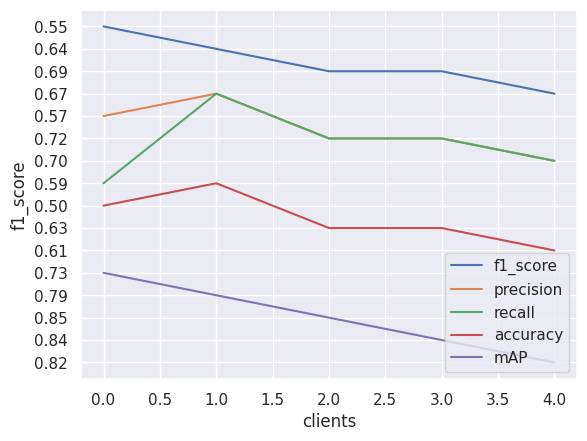

In [24]:
# performance_df plot line
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.lineplot(data=performance_df, x="clients", y="f1_score", label="f1_score")
sns.lineplot(data=performance_df, x="clients", y="precision", label="precision")
sns.lineplot(data=performance_df, x="clients", y="recall", label="recall")
sns.lineplot(data=performance_df, x="clients", y="accuracy", label="accuracy")
sns.lineplot(data=performance_df, x="clients", y="mAP", label="mAP") 
plt.legend(loc='lower right')
plt.show()

In [11]:
# average_precision_score(targets, outputs)

# mAP = 0.0
# for i in range(len(targets)):
#     mAP += average_precision_score(targets[i], outputs[i])
# print(mAP/len(targets), len(targets))